## Problem 1 - Xianghui Gu

### 1.1 Histogram

In [1]:
%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# pass in column names for each CSV and read them using pandas. 
# Column names available in the readme file

cols =  ['user_id','item_id','rating','timestamp']
data = pd.read_csv('q1/u.data', sep='\t', names=cols,
 encoding='latin-1')

In [4]:
movie_ratings = data.item_id.value_counts().to_frame()
user_ratings = data.user_id.value_counts().to_frame()
movie_ratings.columns = ["counts"]
user_ratings.columns = ["counts"]

#### Distribution of #movie_ratings

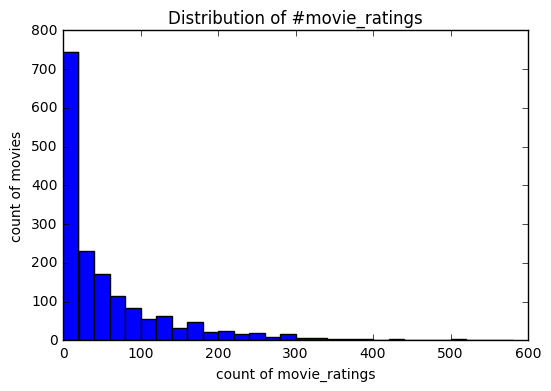

In [5]:
plt.hist(movie_ratings.counts, bins = range(0,max(movie_ratings.counts),20))
plt.title("Distribution of #movie_ratings")
plt.ylabel('count of movies')
plt.xlabel('count of movie_ratings');

#### Distribution of #user_ratings

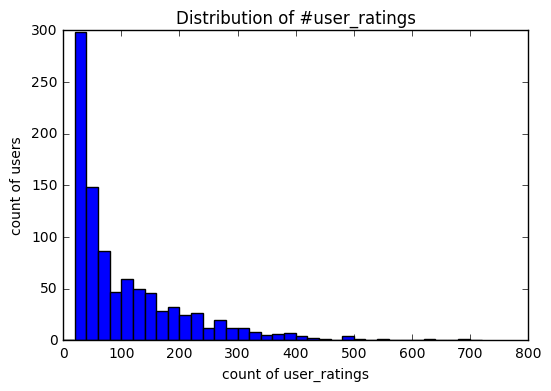

In [6]:
plt.hist(user_ratings.counts, bins = range(0,max(user_ratings.counts),20))
plt.title("Distribution of #user_ratings")
plt.ylabel('count of users')
plt.xlabel('count of user_ratings');

### 1.2 Baseline model

#### 1.2.1 Empirical estimates

- build base and test dataframe

In [8]:
cols =  ['user_id','item_id','rating','timestamp']
uabase = pd.read_csv('q1/ua.base', sep='\t', names=cols,
 encoding='latin-1')
uatest = pd.read_csv('q1/ua.test', sep='\t', names=cols,
 encoding='latin-1')

- Compute $\mu$

In [9]:
mu = uabase.rating.mean()
print("mean score is {:.2f}".format(mu))

mean score is 3.52


- Compute $R(i)$

In [10]:
uabase['bi_dev'] = uabase['rating'] - mu
ri = uabase.groupby('item_id').agg({'bi_dev': ['sum','count']})
ri.head()

bi_dev      
                sum count
item_id                  
1        131.659865   392
2        -39.383052   121
3        -39.525284    85
4          4.282279   198
5        -18.382323    79

- Compute $b_i$ $$b_i=\frac{sum_{r_i}-count_{r_i}\times \mu}{\lambda_2+count_{r_i}}$$


In [11]:
sum_ri = ri['bi_dev']['sum']
count_ri = ri['bi_dev']['count']
lambda_2 = 25.0
bi = pd.DataFrame((sum_ri)/(lambda_2 + count_ri), columns = ['bi'])
bi['item_id'] = bi.index
bi.head()

,bi,item_id
item_id,,
1,0.315731,1
2,-0.269747,2
3,-0.359321,3
4,0.019203,4
5,-0.176753,5


- Compute $R(u)$

In [12]:
uabase_ru = pd.merge(uabase, bi, on='item_id')
uabase_ru['bu_dev'] = uabase_ru['bi_dev'] - uabase_ru['bi']
ru = uabase_ru.groupby('user_id').agg({'bu_dev': ['sum','count']})
ru.head()


bu_dev      
               sum count
user_id                 
1         8.890708   262
2         5.357177    52
3       -21.741278    44
4        13.065696    14
5       -83.290736   165

- Compute $b_u$ $$b_u=\frac{sum_{r_u}-count_{r_u}\times \mu-\sum_{i\in r_u}b_i}{\lambda_3+count_{r_u}}$$

In [13]:
sum_ru = ru['bu_dev']['sum']
count_ru = ru['bu_dev']['count']
lambda_3 = 10.0
bu = pd.DataFrame((sum_ru)/(lambda_3 + count_ru), columns = ['bu'])
bu['user_id'] = bu.index
bu.head()

,bu,user_id
user_id,,
1,0.032686,1
2,0.086406,2
3,-0.402616,3
4,0.544404,4
5,-0.475947,5


- Compute estimated rating and squared error

In [14]:
uatest_rmse = uatest.join( bi, on='item_id',rsuffix = '_right')
uatest_rmse = uatest_rmse.join( bu, on='user_id',rsuffix = '_right')
uatest_rmse.fillna(0,inplace = True)
uatest_rmse['est_rating'] = mu + uatest_rmse.bi + uatest_rmse.bu
uatest_rmse['se'] = (uatest_rmse['est_rating'] - uatest_rmse['rating'])**2
uatest_rmse.head()

,user_id,item_id,rating,timestamp,bi,item_id_right,bu,user_id_right,est_rating,se
0,1,20,4,887431883,-0.127366,20.0,0.032686,1,3.429148,0.325872
1,1,33,4,878542699,-0.049303,33.0,0.032686,1,3.507210,0.242842
2,1,61,4,878542420,0.230441,61.0,0.032686,1,3.786954,0.045389
3,1,117,3,874965739,0.154711,117.0,0.032686,1,3.711225,0.505840
4,1,155,2,878542201,-0.341218,155.0,0.032686,1,3.215295,1.476943


- Keep in mind there are missing values. Set NaN to 0 for terms where  $b_i, b_u=0$ and compute estimated rating

In [15]:
uatest_rmse.loc[(uatest_rmse['bi'] == 0)]

,user_id,item_id,rating,timestamp,bi,item_id_right,bu,user_id_right,est_rating,se
4049,405,1582,1,885548670,0.0,0.0,-1.583563,405,1.940264,0.884097
6749,675,1653,5,889489913,0.0,0.0,-0.138660,675,3.385167,2.607687


- Compute RMSE

In [16]:
import math
rmse = math.sqrt(uatest_rmse.se.sum() / uatest_rmse.shape[0])
print("mean score is {:.5f}".format(rmse))

mean score is 0.96648


#### 1.2.2 Bar chart for average rating

- Obtain average rating for each user

In [17]:
avg = uabase.groupby('user_id').agg({'rating': ['mean']})
avg_series = avg['rating']['mean']
avg['user_id'] = avg.index
avg.columns = avg.columns.droplevel()
avg.columns = ['mean', 'user_id']
avg.head()

,mean,user_id
user_id,,
1,3.603053,1
2,3.750000,2
3,2.909091,3
4,4.357143,4
5,2.909091,5


- Compute range and divide into 5 bins

In [18]:
maxavg = max(avg_series)
minavg = min(avg_series)
print('max: ', maxavg, ' min: ', minavg)

max:  4.92857142857  min:  1.48941176471


In [19]:
import numpy as np
width = (5 - 1.4)/5
mean_bins = np.arange(1.4,5+width-0.0001,width).tolist()
mean_bins

[1.4,
 2.12,
 2.8400000000000003,
 3.5600000000000005,
 4.280000000000001,
 5.000000000000001]

In [20]:
uatest_rmse_avg = uatest_rmse.join( avg, on='user_id',rsuffix = '_right')
uatest_rmse_avg.head()

,user_id,item_id,rating,timestamp,bi,item_id_right,bu,user_id_right,est_rating,se,mean,user_id_right
0,1,20,4,887431883,-0.127366,20.0,0.032686,1,3.429148,0.325872,3.603053,1
1,1,33,4,878542699,-0.049303,33.0,0.032686,1,3.507210,0.242842,3.603053,1
2,1,61,4,878542420,0.230441,61.0,0.032686,1,3.786954,0.045389,3.603053,1
3,1,117,3,874965739,0.154711,117.0,0.032686,1,3.711225,0.505840,3.603053,1
4,1,155,2,878542201,-0.341218,155.0,0.032686,1,3.215295,1.476943,3.603053,1


In [21]:
uatest_rmse_avg_cuts = (uatest_rmse_avg.groupby(pd.cut(uatest_rmse_avg['mean'], mean_bins, right=False)).agg({'se': ['sum','count']}))
uatest_rmse_avg_cuts.columns = uatest_rmse_avg_cuts.columns.droplevel()
uatest_rmse_avg_cuts['rmse'] = ( uatest_rmse_avg_cuts['sum'] / uatest_rmse_avg_cuts['count'])**0.5
uatest_rmse_avg_cuts.rmse

mean
[1.4, 2.12)     1.108866
[2.12, 2.84)    1.155513
[2.84, 3.56)    1.002311
[3.56, 4.28)    0.923977
[4.28, 5)       0.888309
Name: rmse, dtype: float64

- plot RMSE per User

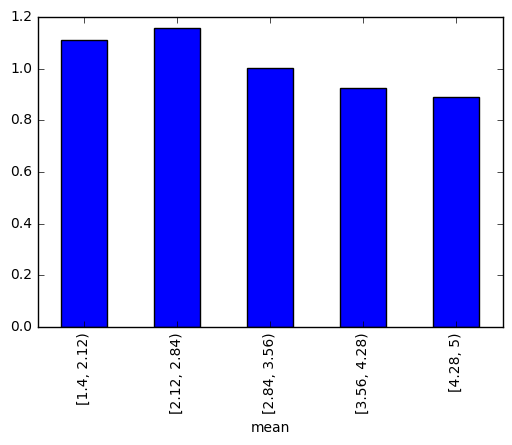

In [22]:
uatest_rmse_avg_cuts.rmse.plot(kind='bar')

### 1.3 KNN with similarity

#### 1.3.1 Test RMSE

- build database for $R_{u,i1},R_{u,i2},\overline{R}_{u}$

In [103]:
uabase_sim = uabase.drop('bi_dev',1)
user_avg_rating = uabase.groupby('user_id').agg({'rating': ['mean']})
user_avg_rating.columns = user_avg_rating.columns.droplevel()
user_avg_rating['user_id'] = user_avg_rating.index

padding = 0.0
uabase_sim = pd.DataFrame.merge(uabase_sim, user_avg_rating, on = 'user_id')
uabase_sim['dev'] = uabase_sim.rating - uabase_sim['mean'] + padding
uabase_sim = uabase_sim.drop(['rating','timestamp','mean'],1)
uabase_sim.shape

(90570, 3)

- Similarity function

In [151]:
### 	user_id	item_id	rating	timestamp	mean	dev	dev_sqimport time
import numpy as np
def similarity(i1,i2,df):
    df1 = df[df['item_id'] == i1][['user_id','dev']]
    df2 = df[df['item_id'] == i2][['user_id','dev']]
    user1 = df1['user_id']
    user2 = df2['user_id']
    intersection = list(set(user1)&set(user2))
    diff_1 = np.array(df1[df1['user_id'].isin(intersection)]['dev'])
    diff_2 = np.array(df2[df2['user_id'].isin(intersection)]['dev'])
    padding = 0.0000000000001
    den = math.sqrt(np.dot(diff_1,diff_1)*np.dot(diff_2,diff_2)) + padding
    num = np.dot(diff_1,diff_2)
    result = num / den
    return result

In [134]:
ind = list(set(uabase_sim['item_id']))

In [161]:
results = pd.DataFrame(index = ind, columns = ind)

- Generate similarity matrix

In [167]:
import time
s = time.time()
size = int(len(ind))
for i in range(0,size):
    for j in range(i+1, size):
        row = ind[i]
        col = ind[j]
        result = similarity(row, col, uabase_sim)
        results.loc[row,col] = result
        results.loc[col,row] = result
t = time.time()
print(t-s)

4190.528391122818


In [169]:
results.to_csv('results.csv', header=True, index=True, sep=',')

In [273]:
results.head()

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,NaN,-0.108454,-0.136499,-0.0994514,0.04588,0.221465,0.157936,0.289928,0.103629,0.0101453,...,0,0,0,0,1,0,0,0,1,-1
2,-0.108454,NaN,0.0871905,0.0271035,0.0537869,-0.0809238,-0.146082,-0.0321082,-0.395071,-0.0580062,...,0,0,0,0,0,0,0,0,1,1
3,-0.136499,0.0871905,NaN,-0.368733,0.100174,0.18139,-0.263176,-0.500832,-0.190023,-0.417661,...,0,0,0,0,1,0,0,0,0,1
4,-0.0994514,0.0271035,-0.368733,NaN,-0.313544,-0.200958,-0.00324608,0.224042,0.0748943,-0.0292339,...,0,0,-1,-1,1,0,0,0,1,-1
5,0.04588,0.0537869,0.100174,-0.313544,NaN,-0.948415,-0.0900145,0.046442,-0.225091,-0.540575,...,0,0,0,0,0,0,0,0,0,1


In [280]:
junk = pd.read_csv('results.csv', sep=',',
 encoding='latin-1')

In [281]:
res = junk.as_matrix()

In [289]:
res = np.nan_to_num(res) + padding

- compute knn (if not watched, use the total mean as estimated rating)

In [373]:
### k, sim_mat(np matrix), base(df), test(mat)
def knn(k, sim_mat, base, test):
    se = 0.0
    for row in range(len(test)):
        user = test[row][0]
        item = test[row][1] - 1 ### similarity matrix starting from 0
        temp = base[base["user_id"] == user][["item_id","rating"]]
        has_watched = temp["item_id"].as_matrix() - 1
        has_watched_rating = temp["rating"].as_matrix()        
        has_watched_sim = sim_mat[item,has_watched]
        ind = np.argpartition(has_watched_sim, -k)[-k:]
        top_sim = has_watched_sim[ind]
        top_rating = has_watched_rating[ind]
        est_rating = np.dot(top_sim, top_rating) / abs(top_sim).sum()
        if not (est_rating > 0):
            est_rating = mu
        se += (est_rating - test[row][2])**2

    return math.sqrt(se/len(test))

In [314]:
uatest_mat = uatest.as_matrix()
uatest_mat.shape

(9430, 4)

In [294]:
rmse_knn = []
for kk in [1,2,3,5,10]:    
    temp = knn(kk, res, uabase, uatest_mat)
    rmse_knn.append(temp)

- Compare results for k

In [297]:
cand = [1,2,3,5,10]
for kk in range(len(rmse_knn)):
    print(cand[kk],": RMSE = ", rmse_knn[kk])

1 : RMSE =  1.3725068981895656
2 : RMSE =  1.1889511068180696
3 : RMSE =  1.1201927728908965
5 : RMSE =  1.0766621749781962
10 : RMSE =  1.3284979186425898


Hence, k = 5 has the best result.

- Divide 5 bins based on average rating

In [321]:
cats = pd.cut(uatest_rmse_avg['mean'], 5, right=False)

In [322]:
uatest_knn = uatest
uatest_knn["cat"] = cats
uatest_knn.head()

,user_id,item_id,rating,timestamp,cat
0,1,20,4,887431883,"[3.553, 4.241)"
1,1,33,4,878542699,"[3.553, 4.241)"
2,1,61,4,878542420,"[3.553, 4.241)"
3,1,117,3,874965739,"[3.553, 4.241)"
4,1,155,2,878542201,"[3.553, 4.241)"


In [333]:
user_bins = list(set(uatest_knn["cat"].as_matrix()))
user_bins.sort()
user_bins

['[1.489, 2.177)',
 '[2.177, 2.865)',
 '[2.865, 3.553)',
 '[3.553, 4.241)',
 '[4.241, 4.932)']

In [379]:
### k, sim_mat(np matrix), base(df), test(mat)
### def knn(k, sim_mat, base, test):
rmse_tot = []
cand = [1,2,3,5,10]
for kk in cand:
    rmse_knn = []
    for i in range(len(user_bins)):
        b = user_bins[i]
        df_knn = uatest_knn[uatest_knn["cat"]==b][["user_id","item_id","rating"]].as_matrix()
        temp =  knn(kk, sim_mat, uabase, df_knn)
        rmse_knn.append(temp)
    rmse_tot.append(rmse_knn)

 
    

- Plot 5 bar charts for 5 k's

k= 1


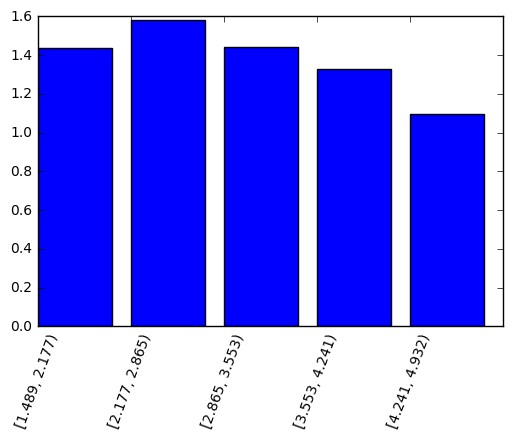

k= 2


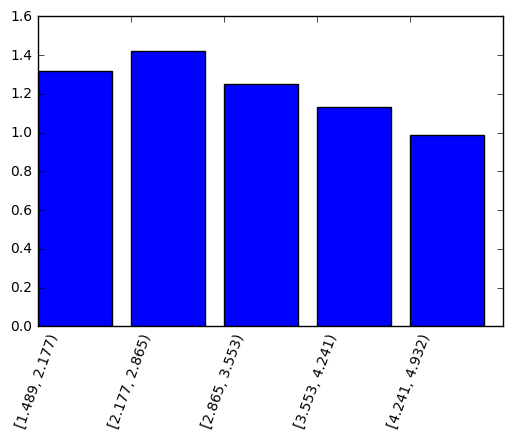

k= 3


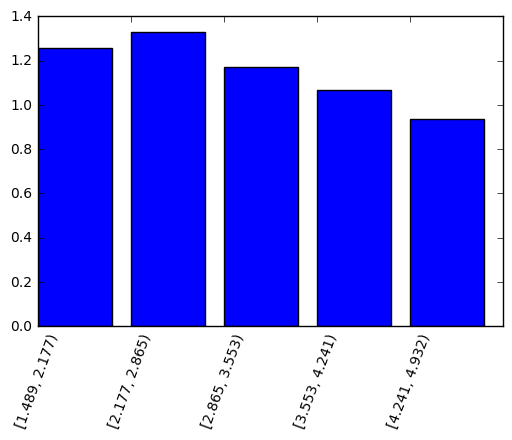

k= 5


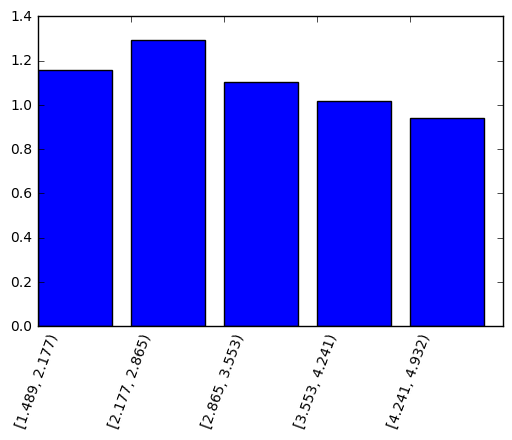

k= 10


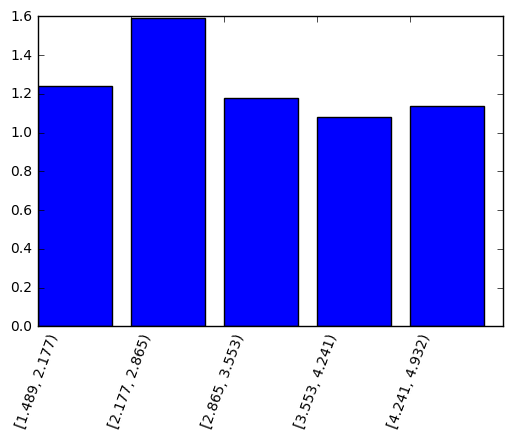

In [385]:
for i in range(len(cand)):
    print("k=", cand[i])
    plt.bar(range(len(cand)),rmse_tot[i])
    plt.xticks(range(len(cand)), user_bins)
    plt.xticks(rotation=70)
    plt.show()